In [1]:
import torch.distributions as dist
import numpy as np
import torch.distributions as dist
import torch
import vsms
import importlib
import vsms.exsample_benchmark
import vsms.exsample_sampler
importlib.reload(vsms.exsample_benchmark)
importlib.reload(vsms.exsample_sampler)
from vsms.exsample_benchmark import *
from vsms.exsample_sampler import *
from vsms.exsample_analytic import *
from vsms.exsample_simulation import *
import scipy.stats
import pandas as pd

In [2]:
# normal dist: 95% are within 2sigma
np.set_printoptions(precision=3, suppress=True)

In [3]:
NF = int(2**24)
N = 2000

In [4]:
durations = torch.load('./durations.pth')
positions = torch.load('./positions.pth')
starts, ends = generate_tracks(positions, durations, NF) # skew 1/32
mm = make_multi_map(starts[:,-2], ends[:,-2])

In [137]:
f,s = make_score_order(mm, N)

In [138]:
fs = FrameScoreOrder(f, s, gap=0)

In [269]:
dist.Normal(1., 0).sample((10,))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [270]:
def make_frame_scores(mm : ArrayMultiMap, N : int, 
                     positive_sigma=0., negative_sigma=0.):
    """
    :param mm: frames => tids
    :param N: total number of instances
    :return: a score for each frame, and the ordering on frames
    based on a decreasing score
    """
    scores_pos = dist.Normal(1., positive_sigma).sample((N,)).numpy()
    scores_neg = dist.Normal(0., negative_sigma)
    frscore = scores_pos[mm.ovalues]
    np.unique(mm.okeys).shape
    unq_keys, cts = np.unique(mm.okeys, return_counts=True)
    accs = frscore.cumsum()
    tots = cts.cumsum()
    lastaccs = accs[tots-1]
    frame_total = np.diff(lastaccs, prepend=0)
    return unq_keys, frame_total

In [130]:
bm = pr.BitMap([])

In [ ]:
bm.add_range()

In [271]:
from collections import deque

def rank_scores(score):
    """
    :param score: score array
    :return: returns ranking from highest to
    lowest score, while randomizing order of any score-ties
    """
    score = -score #  want ascending scores
    tiebreaker = np.random.randn(*score.shape)
    idx1 = np.argsort(tiebreaker)
    score = np.take_along_axis(score,idx1,axis=-1)
    idx2 = np.argsort(score, kind='stable')
    idx = np.take_along_axis(idx1,idx2,axis=-1)
    return idx

class FrameScoreOrder(Sampler):
    """
    Return the highest scoring frames which are not near previous frames
    If a frame has a positive result, then de-prioritize frames one GAP away.
    GAP = 1 means no deprioritizing
    Once we have gone through the remaining frames, come back once more to those
    frames which were near previously delayed frames
    """
    
    def __init__(self, frame_ids, frame_scores, gap=1):
        super().__init__()
        idxs = rank_scores(frame_scores)
        self.frame_ids = frame_ids[idxs]
        self.frame_scores = frame_scores[idxs]
        assert gap >= 1 # gap of 1 allows neighbors
        self.gap = gap

        # state
        self.queue = deque(self.frame_ids)
        self.pending = deque()
        self.delayed_ranges = pr.BitMap([])
                
    def _remaining(self):
        return len(self.queue) + len(self.pending)

    def nf(self):
        return len(self.frame_ids) - self._remaining()
    
    def _next(self):
        ret = -1
        if self._remaining() == 0:
            return -1
        
        while len(self.queue) > 0:
            ret = self.queue.popleft()
            if ret in self.delayed_ranges:
                self.pending.append(ret)
            else:
                return ret
            
        # reset state to go through pending frames in similar fashion
        assert len(self.queue) == 0
        self.queue = self.pending
        self.pending = deque()
        self.delayed_ranges = pr.BitMap([])
        return self._next()
            
    def next_batch(self, n):
        ret = []
        for _ in range(n):
            r = self._next()
            if r >= 0:
                ret.append(r)
            else:
                break
                
        return (np.array(ret), None)
    
    def feedback(self, batch, match_ids):
        # delay frames near previous frames with positive results
        (ilocs, _) = batch
        for (i,ms) in zip(ilocs, match_ids):
            if len(ms) > 0: 
                start = max(i-self.gap + 1, 0)
                self.delayed_ranges.add_range(start, i+self.gap)

In [147]:
# checks:
# 1) gap=0 means it just returns frame ids.
# 2) try some random gap and check it returns all frame ids eventually

In [232]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [272]:
def testFrameScoreOrder():
    f = np.arange(1000)
    s = np.arange(1., 0., step=-1./f.shape[0])
    ## score max to 0
    scramble = np.random.permutation(f.shape[0])
    f = f[scramble]
    s = s[scramble]
    
    def checkFirst():
        fso = FrameScoreOrder(frame_ids=f, frame_scores=s, gap=1)
        fst = fso.next_batch(n=1)
        assert fst[0] == 0
    checkFirst()

    ## check I get everything
    def checkSequential():
        rets = []
        fso = FrameScoreOrder(frame_ids=f, frame_scores=s, gap=1)
        while True:
            (ilocs, _) = fso.next_batch(n=1)
            if len(ilocs) == 0:
                break
            rets.append(ilocs[0])
        assert (np.array(rets) == np.arange(f.shape[0])).all()
    checkSequential()
        

    def checkGapNoPositive():
        rets = []
        fso = FrameScoreOrder(frame_ids=f, frame_scores=s, gap=100)
        while True:
            (ilocs, _) = fso.next_batch(n=1)
            if len(ilocs) < 1:
                break
            rets.append(ilocs[0])
            # no positives
            fso.feedback((ilocs,None), [[] for _ in range(len(ilocs))])
            
        retset = set(rets)
        assert len(retset) == len(rets)
        assert set(rets) == set(f)
    checkGapNoPositive()
        
    def checkGap():
        rets = []
        fso = FrameScoreOrder(frame_ids=f, frame_scores=s, gap=100)
        while True:
            (ilocs, _) = fso.next_batch(n=1)
            if len(ilocs) < 1:
                break
            rets.append(ilocs[0])
            fso.feedback((ilocs, None), match_ids=[[i] for i  in range(len(ilocs))])

        retset = set(rets)
        assert len(retset) == len(rets)
        assert set(rets) == set(f)
        post_order = np.array(rets)
        assert (post_order[:10] == np.arange(0,1000,step=100)).all()
        assert (post_order[10:20] == np.arange(1,1001,step=100)).all()
    checkGap()
    
testFrameScoreOrder()

In [273]:
def gen_exp_partitions(mm, ps, Ms):
    ans = []
    ps = ps.reshape(-1)

    for i,M in enumerate(Ms):
        Ps = getPs(mm, N, NF, NF//M)
        ans.append({'params':{'NF':NF,
                              'N':N,
                            'minp':ps.min().item(),
                            'mup':ps.mean().item(), 
                            'maxp':ps.max().item(),
                            'sigmap':ps.std().item(), 
                            'M':M},
                    'mm':mm,
                    'Ps':Ps})
        assert Ps.shape[1] == M
        assert np.isclose(Ps.mean(axis=1), ps).all()
        assert (Ps <= 1.).all()
        assert (Ps >= 0.).all()
    return ans

In [274]:
setups = gen_exp_partitions(mm, ps, np.array([128]))

In [279]:
#frames = np.arange(NF).astype('int')
def make_experiment(mm, batch_size, score, score_params, other_params):
    g = Grader(mm, pr.BitMap([]))
    
    if score == 'random1':
        s = RandomlyPermutedRange(0, NF)
    elif score == 'framescore':
        frames, scores = make_frame_scores(mm, N, positive_sigma=score_params['score_sigma'])
        s = FrameScoreOrder(frames, scores, gap=score_params['gap'])
    else:
        M = other_params['M']
        fpc = NF//M
        samplers = [RandomlyPermutedRange(start=fpc*i, end=fpc*(i+1)) for i in range(M)]
        if score == 'gt':
            sm = GtScore
        elif score == 'statscorer':
            sm = StatScorer
        elif score == 'random':
            sm = RandomScore
        else:
            assert False
        
        s = CompositeSampler(samplers, NI=N, score_method=sm, score_opts=score_params)

    params={'score':score}
    params.update(score_params)
    params.update(other_params)
    exp = Experiment(sampler=s, grader=g, params=params, param_names=params, 
                     NI=N, NF=NF, batch_size=batch_size)
    return exp

In [276]:
def skew_metric(Ps, fraction=.5):
    Ns = (Ps > 0).sum(axis=0)
    order = np.argsort(-Ns)
    ons = Ns[order]
    fracs = ons/sum(ons)
    needed = (fracs.cumsum() < fraction).sum() + 1
    return Ps.shape[1]/needed

In [277]:
def make_composite(df, cols):
    df = df[cols]
    tot = df[df.columns[0]]
    for c in df.columns[1:]:
        tot = tot + '_' + df[c].map(str)
    return tot

In [59]:
# current goal: explain greedy scoring vs. sampling
# it will help explain results.

In [302]:
exps4 = []
for ent in setups:
    for i in range(5):
        es = [
                make_experiment(ent['mm'], batch_size=1, score='random1', 
                                     score_params=dict(stat='dummy', exp_model='dummy'),
                                     other_params=ent['params']),
                make_experiment(ent['mm'], batch_size=1, score='statscorer', 
                                score_params=dict(stat='gt', exp_model='ts'), 
                                other_params=ent['params']),
                make_experiment(ent['mm'], batch_size=1, score='framescore',
                                score_params=dict(stat='gt', exp_model='ts',
                                                  gap=100, score_sigma=0), 
                                other_params=ent['params']),
                make_experiment(ent['mm'], batch_size=1, score='framescore',
                                score_params=dict(stat='gt', exp_model='ts',
                                                  gap=100, score_sigma=.1), 
                                other_params=ent['params']),
            #                 make_experiment(mm, batch_size=1, score='statscorer', 
#                                 score_params=dict(stat='gt', exp_model='bayes_ucb'), 
#                                 other_params=dict(M=M, x=x)),
#                 make_experiment(mm, batch_size=1, score='statscorer', 
#                                 score_params=dict(stat='unique', exp_model='ts'), 
#                                 other_params=dict(M=M, x=x)),
#                 make_experiment(mm, batch_size=1, score='statscorer', 
#                                 score_params=dict(stat='gt', exp_model='none'), 
#                                 other_params=dict(M=M, x=x))
        ]
        exps4.extend(es)

In [303]:
for exp in tqdm(exps4):
    exp.run_up_to(threshold=5000, metric='frames')

In [341]:
res = []
for exp in exps4:
    r = exp.get_results()
    res.append(r)

In [342]:
all_res = pd.concat(res)
df = all_res

In [343]:
df.method.unique()

array(['random1_dummy_dummy_16777216_2000_3.337860107421875e-06_4.159343242645264e-05_0.0003134012222290039_2.930580244735737e-05_128',
       'statscorer_gt_ts_16777216_2000_3.337860107421875e-06_4.159343242645264e-05_0.0003134012222290039_2.930580244735737e-05_128',
       'framescore_gt_ts_100_0_16777216_2000_3.337860107421875e-06_4.159343242645264e-05_0.0003134012222290039_2.930580244735737e-05_128',
       'framescore_gt_ts_100_0.1_16777216_2000_3.337860107421875e-06_4.159343242645264e-05_0.0003134012222290039_2.930580244735737e-05_128'],
      dtype=object)

In [321]:
def mn(m):
    if m.startswith('random1'):
        return 'random'
    elif m.startswith('statscorer'):
        return 'this work'
    elif m.startswith('framescore_gt_ts_100_0_'):
        return 'perfect frame score'
    elif m.startswith('framescore_gt_ts_100_0.1_'):
        return 'varying perfect frame score'
    else:
        assert False

In [323]:
df = df.assign(method=df.method.map(mn))

In [306]:
from plotnine import *

In [324]:
# df = df.assign(method=make_composite(df, ['score', 'stat', 'exp_model', 'M']))
df = df.assign(task='t')
#df = df.assign(method=df.method.fillna('random'))
#df = df.assign(duration=(df.mup*NF).astype('int')//30, chunks=df.M)
# df = df.assign(method=df.score)#df.method.map(lambda x: x.split('_')[0] if x.endswith('gt_ts') else 'random'))

In [325]:
df

,timestamp,ni,nf,wall_clock,score,stat,exp_model,NF,N,minp,...,M,experiment_id,method,params,instance_f,frame_f,NI,gap,score_sigma,task
0,1.599674e+09,0,0,0.000000,random1,dummy,dummy,16777216,2000,0.000003,...,128,7080404209362723575,random,random1_dummy_dummy_16777216_2000_3.3378601074...,0.0000,0.000000e+00,2000,NaN,NaN,t
1,1.599674e+09,0,6,5.487427,random1,dummy,dummy,16777216,2000,0.000003,...,128,7080404209362723575,random,random1_dummy_dummy_16777216_2000_3.3378601074...,0.0000,3.576279e-07,2000,NaN,NaN,t
2,1.599674e+09,3,7,5.487434,random1,dummy,dummy,16777216,2000,0.000003,...,128,7080404209362723575,random,random1_dummy_dummy_16777216_2000_3.3378601074...,0.0015,4.172325e-07,2000,NaN,NaN,t
3,1.599674e+09,3,8,5.487995,random1,dummy,dummy,16777216,2000,0.000003,...,128,7080404209362723575,random,random1_dummy_dummy_16777216_2000_3.3378601074...,0.0015,4.768372e-07,2000,NaN,NaN,t
4,1.599674e+09,5,9,5.488004,random1,dummy,dummy,16777216,2000,0.000003,...,128,7080404209362723575,random,random1_dummy_dummy_16777216_2000_3.3378601074...,0.0025,5.364418e-07,2000,NaN,NaN,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,1.599674e+09,1998,3948,39.631045,framescore,gt,ts,16777216,2000,0.000003,...,128,8025630163183545708,varying perfect frame score,framescore_gt_ts_100_0.1_16777216_2000_3.33786...,0.9990,2.353191e-04,2000,100.0,0.1,t
1700,1.599674e+09,1999,3949,39.631051,framescore,gt,ts,16777216,2000,0.000003,...,128,8025630163183545708,varying perfect frame score,framescore_gt_ts_100_0.1_16777216_2000_3.33786...,0.9995,2.353787e-04,2000,100.0,0.1,t
1701,1.599674e+09,1999,3959,39.632301,framescore,gt,ts,16777216,2000,0.000003,...,128,8025630163183545708,varying perfect frame score,framescore_gt_ts_100_0.1_16777216_2000_3.33786...,0.9995,2.359748e-04,2000,100.0,0.1,t
1702,1.599674e+09,2000,3960,39.632307,framescore,gt,ts,16777216,2000,0.000003,...,128,8025630163183545708,varying perfect frame score,framescore_gt_ts_100_0.1_16777216_2000_3.33786...,1.0000,2.360344e-04,2000,100.0,0.1,t


In [326]:
# df = df.assign(method=make_composite(df, ['score', 'stat', 'exp_model']), 
#               M1=df.M.map(str), dur1=df.dur_coeff.map(str))
# df = df.assign(task=make_composite(df, ['M1', 'dur1']))
# df = df.assign(method=df.method.fillna('random'))
# #df = df.assign(duration=(df.mup*NF).astype('int')//30, chunks=df.M)
#df = df.assign(method=df.method.map(lambda x : ))

In [327]:
df['method'].unique(), df['task'].unique()

(array(['random', 'this work', 'perfect frame score',
        'varying perfect frame score'], dtype=object),
 array(['t'], dtype=object))

In [1030]:
# rs = []
# for level in [10,100,1000]:
#     rel_savings = savings_at(df, fixed_metric='ni', fixed_metric_level=level, measured_metric='nf',
#            task_keys=['task', 'dur_coeff', 'skew'], 
#            method_keys=['method'],
#            reference_method=('random')).assign(level=level)
#     rs.append(rel_savings)
    
# rel = pd.concat(rs)
# rel = rel[rel.method.isin(['this work', 'random1_dummy_dummy'])]
# #rel = rel.assign(skew=rel['skew'])
# rel = rel.assign(mid=np.sqrt(rel.ref*rel.metric))
# rel = rel.dropna(axis=0)

In [329]:
svgs = []
#levels = [np.arange(100)]
levels = [np.arange(1,50,1),
          np.arange(50,300,step=5),
          np.arange(300,500,step=5),
          np.arange(500,1000,step=10),
          np.arange(1000,3000,step=20),
          np.arange(3000,5000,step=50),
         ]
#          np.arange(5000,20000,step=500)]
#, np.arange(1500,20000,step=500)]
all_levels = sum(map(list,levels),[])

for level in all_levels:    
    svgs.append(savings_at(df, fixed_metric='nf',
                           fixed_metric_level=level,
                           measured_metric='ni',
                           task_keys=['task'],# 'dur_coeff', 'skew'], 
                           method_keys=['method'],
                           quantiles=[.25,.5,.75],
                           reference_method=('random1')).assign(level=level))

svgs = pd.concat(svgs, ignore_index=True)
#svgs = svgs.assign(method=make_composite(svgs, ['score']))
svgs = svgs.assign(ratio=svgs.ratio.pow(-1))
#svgs = svgs.assign(duration=svgs.duration)

In [330]:
svgs

,task,method,lower,metric,upper,ratio,ref,level
0,t,perfect frame score,11.0,11.0,11.0,NaN,NaN,1
1,t,random,0.0,0.0,0.0,NaN,NaN,1
2,t,this work,0.0,0.0,0.0,NaN,NaN,1
3,t,varying perfect frame score,11.0,11.0,11.0,NaN,NaN,1
4,t,perfect frame score,22.0,22.0,22.0,NaN,NaN,2
...,...,...,...,...,...,...,...,...
1266,t,this work,1766.0,1767.0,1768.0,NaN,NaN,4850
1267,t,random,338.0,349.0,354.0,NaN,NaN,4900
1268,t,this work,1768.0,1768.0,1772.0,NaN,NaN,4900
1269,t,random,340.0,354.0,356.0,NaN,NaN,4950


In [313]:
import plotnine.facets.labelling

In [314]:
def lskew(x):
    ans = f'skewed toward\n1/{int(float(x))} of dataset' if x != '1.0' else 'no instance skew'
    return ans

def lchunks(x):
    ans = f'dataset split into\nM={x} chunks'
    return ans

def ldur(x):
    dur = int(round(float(x)*700))
    ans = 'mean duration\n{} frames'.format(dur)
    return ans

lab = plotnine.facets.labeller(rows=as_labeller(ldur), cols=as_labeller(lskew))

In [331]:
pdf = svgs #[svgs.method.isin(['random', 'this work', 'random1_dummy_dummy'])]
pdf = pdf.assign(lower=pdf.lower.round(), 
                metric=pdf.metric.round(),
                upper=pdf.upper.round())

In [332]:
pdf.method.unique()

array(['perfect frame score', 'random', 'this work',
       'varying perfect frame score'], dtype=object)

In [ ]:
#dfmodel = dfmodel.assign(M=dfmodel.M.fillna(0).astype('int'))

In [120]:
#dfmodel = dfmodel.assign(method=make_composite(dfmodel, ['method', 'M']).map(lambda x : 'random' if x.startswith('random') else x.split('_')[-1]))

In [121]:
#dfmodel.groupby('method').size(), pdf.groupby('method').size()

In [333]:
#dodge_text = position_dodge2(width=4)
xmin=10.
simplot = (ggplot(pdf)
 + geom_ribbon(aes(x='level', ymin='lower',ymax='upper',fill='method'), alpha=.2, color=None)
 + geom_line(aes(x='level', y='metric', color='method'))
#  + geom_line(aes(x='nf', y='ni', color='method'),
#              data=dfmodel.dropna(axis=0), 
#              linetype='--', alpha=1.)
 #+ geom_point(aes(x='level', y='metric', color='method'))
 #+ geom_segment(aes(x='ref', xend='metric', y='level', yend='level'), data=rel.assign(ref=rel.ref.clip(xmin+.1)))
#  + geom_text(aes(x='mid', y='level', label='ratio'), format_string='{:2.2g}x',
#              ha='center', va='bottom', data=rel)
#+ facet_wrap(facets=['M'], scales='free', labeller='label_both')
# + facet_grid(facets=['dur_coeff','skew'], scales='free', labeller=lab)
 + theme(panel_grid_minor=element_blank(),
         figure_size=(7,4),
         subplots_adjust={'hspace':.0, 'wspace':.0},
         panel_border=element_line(color='black'),
        legend_position='top',
        legend_direction='horizontal', 
         legend_title=element_blank(),
         strip_text=element_text(size=8),
         plot_margin=0,
         legend_margin=0,
         legend_box_margin=0,
         strip_margin=0
        )
+ scale_x_log10(name='number of frames sampled (out of {:d} Million)'.format(int(NF//(1e6))), breaks=[10.,100.,1000.,10000],)
#                  labels=[10, 100, '1k', '10k'],
#                  limits=np.array([xmin,30000.]))
+ scale_y_log10(name=f'number of distinct instances found (out of {N})', breaks=[1.,10.,100.,1000.,2000.])
#                  labels=[1, 10, 100, '1k', '2k'],
#                  limits=[1.,3000.])
 + annotate('hline', yintercept=2000., color='gray', alpha=.5)
#  + geom_line(aes(x='n', y='pred'), data=dfmodel,linetype='--', alpha=.5)
 # + geom_text(aes(x='method', y=0, label='method'), va='bottom', angle=90)
 # + geom_text(aes(x='level', y='ratio', label='metric'), va='top')
 # + geom_text(aes(x='level', y='ratio', label='ratio'), va='bottom', format_string='{:0.1f}x')
 # + annotate('hline', yintercept=1., color='black')
)

In [340]:
# show effect of average duration
# and duration skew on perfect score
np.quantile(durations, .05)

200.95

/nvme_drive/vsms3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10


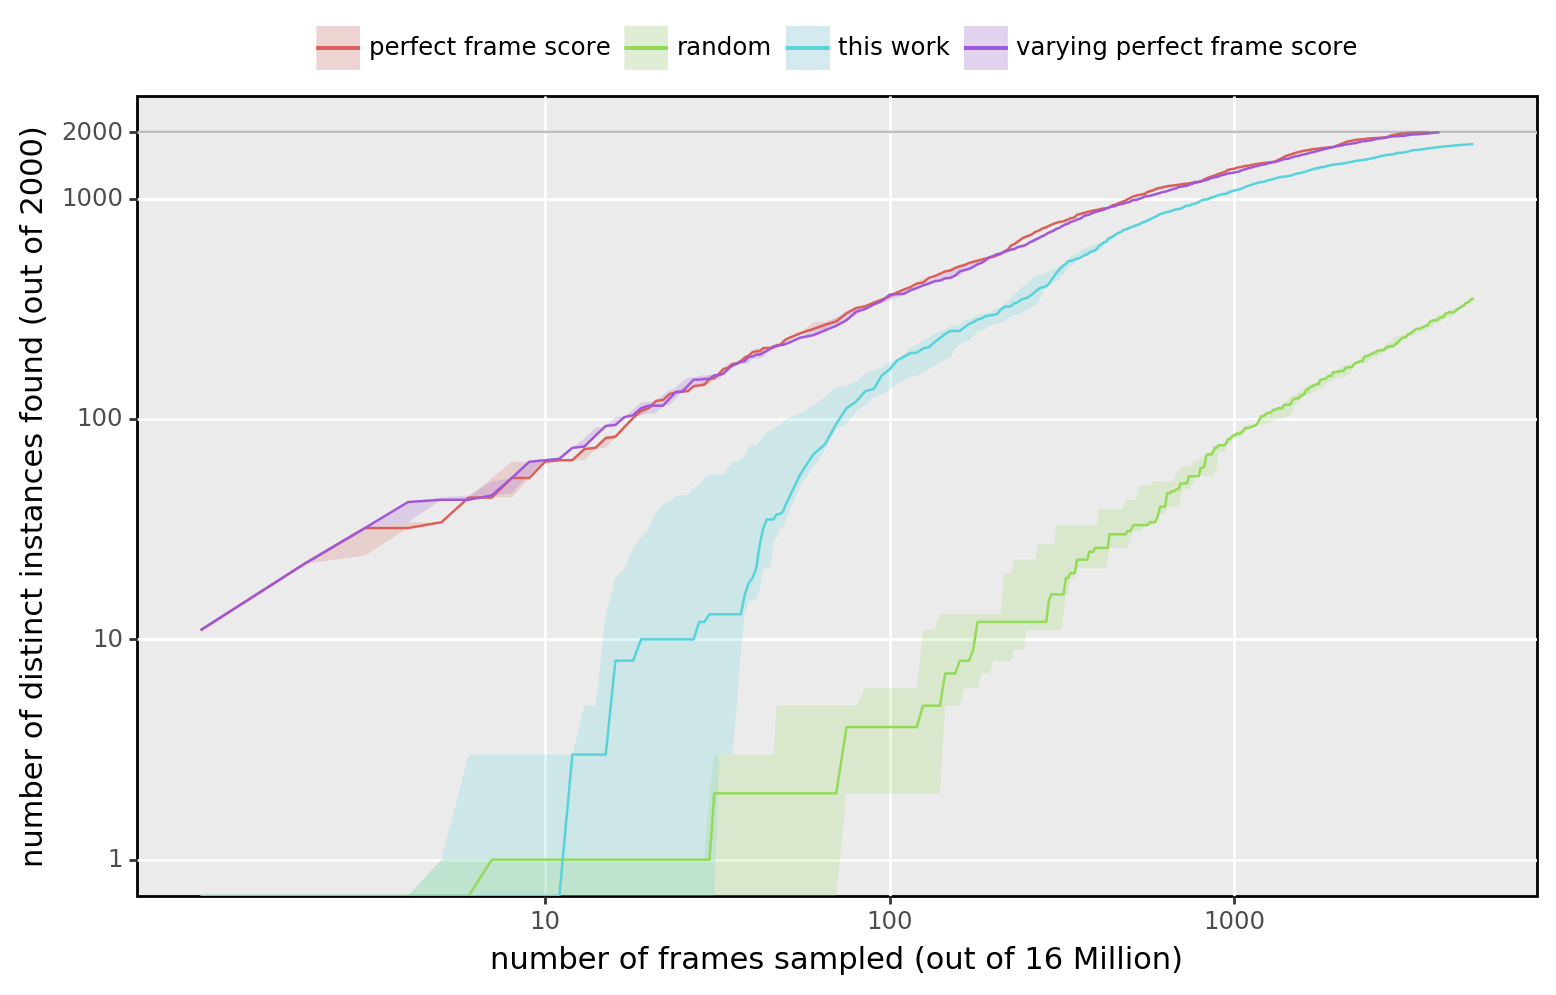

<ggplot: (8726517005253)>

In [334]:
simplot

In [1311]:
pm = pdf.merge(dfmodel[['method', 'nf', 'ni']], how='left', left_on=('method', 'level'), right_on=('method', 'nf'))

In [1312]:
pm

,task,method,lower,metric,upper,ratio,ref,level,nf,ni
0,t,1024,0,0,0,1.000000,0,1,1,4.400408
1,t,128,0,0,0,1.000000,0,1,1,3.855026
2,t,16,0,0,0,1.000000,0,1,1,1.328688
3,t,2,0,0,0,1.000000,0,1,1,0.166367
4,t,random,0,0,0,1.000000,0,1,1,0.083187
...,...,...,...,...,...,...,...,...,...,...
2340,t,1024,1884,1899,1908,1.513944,1254,29500,29500,1999.818522
2341,t,128,1975,1979,1983,1.577689,1254,29500,29500,1999.479909
2342,t,16,1991,1992,1995,1.588048,1254,29500,29500,1997.474225
2343,t,2,1634,1653,1658,1.317928,1254,29500,29500,1647.187363


In [1262]:
#pm.method[pm.nf.isna()].shape[0]

In [1313]:
pm = pm.assign(gap=(pm['ni'] - pm['metric']))

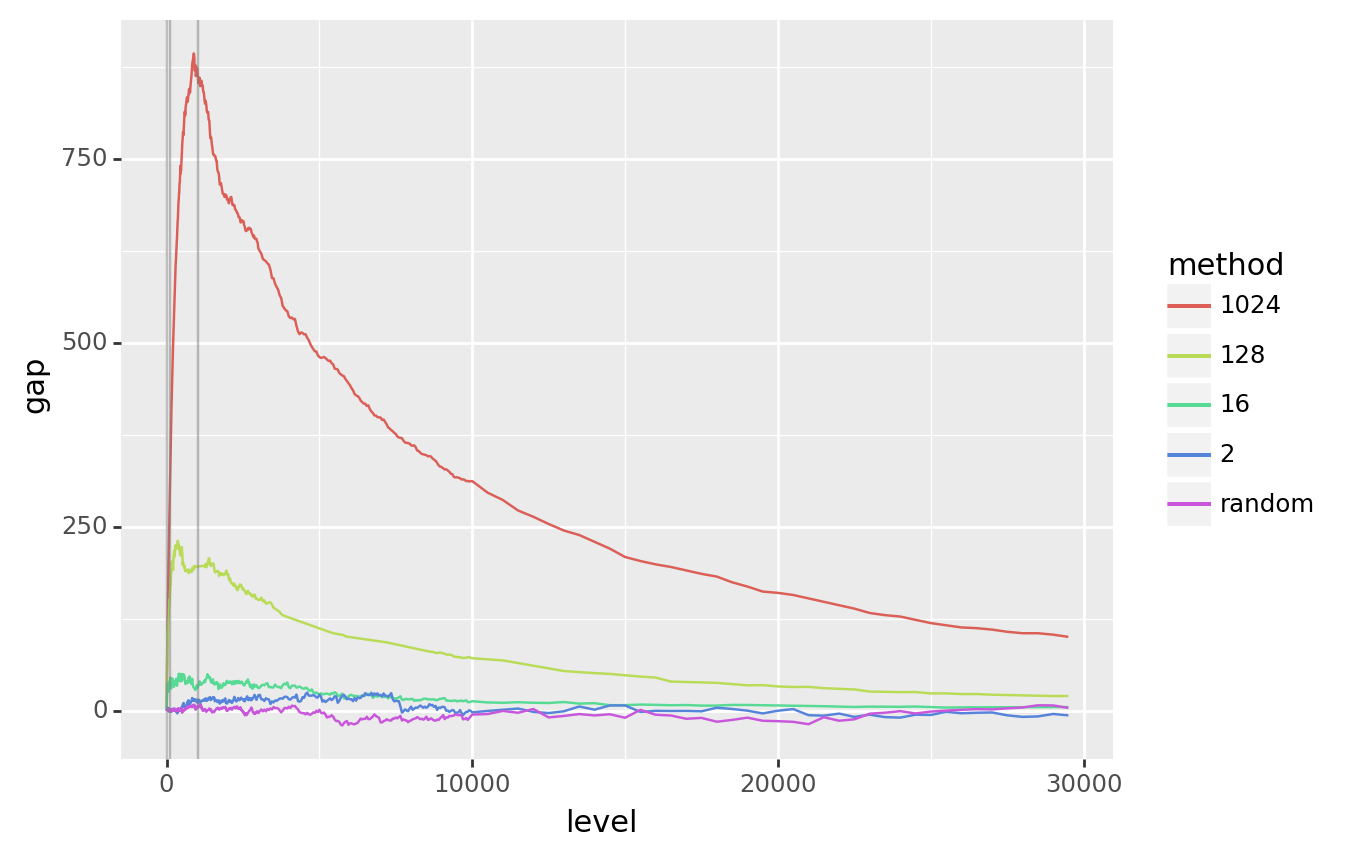

<ggplot: (8782964421931)>

In [1321]:
(ggplot(pm.dropna(axis=0)) 
 + geom_line(aes(x='level', y='gap', color='method'))
 # + scale_x_log10(name='number of samples', breaks=[1.,10.,100.,1000.,2000.], limits=np.array([10.,4000.]))
 + annotate('vline', xintercept=[16,128,1024], color='gray',alpha=.5))
# + scale_y_log10(name='result gap', breaks=[1.,10.,100.,1000.,2000.], limits=[1.,3000.]))

In [ ]:
#dodge_text = position_dodge2(width=4)
(ggplot(svgs[svgs.method.isin(['random', 'this work'])])
 + geom_ribbon(aes(x='level', ymin='lower',ymax='upper',fill='method', group=), alpha=.2, color=None)
 + geom_line(aes(x='level', y='metric', color='method'))
 + geom_line(aes(x='n', y='N', color='method'), data=dfmodel, linetype='--', alpha=1.)
 #+ geom_point(aes(x='level', y='metric', color='method'))
 + geom_segment(aes(x='ref', xend='metric', y='level', yend='level'), data=rel)
 + geom_text(aes(x='mid', y='level', label='ratio'), format_string='{:.01f}x', ha='center', va='bottom', data=rel)
 + facet_grid(facets=['skew', 'chunks'], scales='free', labeller='label_both', )
 + theme(panel_grid_minor=element_blank(),
         figure_size=(4*3,2*4.5),
         subplots_adjust={'hspace':.0, 'wspace':.0},
         panel_border=element_line(color='black')
        )
 
 + scale_x_log10(name='number of samples', breaks=[1.,10.,100.,1000.,2000.], limits=np.array([10.,4000.]))
 + scale_y_log10(name='number of results', breaks=[1.,10.,100.,1000.,2000.], limits=[1.,3000.])
 + annotate('hline', yintercept=2000., color='gray', alpha=.5)
 
#  + geom_line(aes(x='n', y='pred'), data=dfmodel,linetype='--', alpha=.5)
 # + geom_text(aes(x='method', y=0, label='method'), va='bottom', angle=90)
 # + geom_text(aes(x='level', y='ratio', label='metric'), va='top')
 # + geom_text(aes(x='level', y='ratio', label='ratio'), va='bottom', format_string='{:0.1f}x')
 # + annotate('hline', yintercept=1., color='black')
)

In [626]:
svgs[['metric', 'level', 'upper', 'lower', 'method', 'skew', 'chunks']].isna().any()

metric    False
level     False
upper     False
lower     False
method    False
skew      False
chunks    False
dtype: bool